In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import os, sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import *
from imblearn.combine import SMOTETomek
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import warnings
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import nevergrad as ng
from concurrent import futures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import LabelEncoder
import random


### **Descripción de el proyecto**


El proyecto consiste en desarrollar un algoritmo de Machine Learning.
<br>A partir de una imagen de un tumor de Cervix, asigna el tipo de tratamiento que mejor funcionaría en cada caso, atendiendo a esta imagen que explica más detalladamente la clasificación.

<img src=https://storage.googleapis.com/kaggle-competitions/kaggle/6243/media/Screen%20Shot%202017-03-09%20at%205.20.01%20PM.png width="600" height="337"> 

Este proyecto se basa en una competición de Kaggle lanzada por Intel y MobileODT. <br>
Visitar <a href="https://www.kaggle.com/competitions/intel-mobileodt-cervical-cancer-screening/overview">Kaggle</a> para mas información.

### **Importación de imágenes**

Importo las imagenes de los tres tipos que tengo guardadas en sus respectivos tres ficheros. <br>
En la función preprocess primero importo las imagenes; las reescalo usando openCV; tras esto, las recorto para eliminar los bordes, ya que no son determinantes en relación a la clasificación; las cambio a niveles de gris; aplico una máscara de convolución laplaciana, para dejar las partes significativas de la imagen en color blanco y las zonas del fondo en negro; por último ecualizo el histograma para obtener mejores resultados.

In [3]:
x_data = []

mLap = np.array([[-1,-1,-1],
                [-1,8,-1],
                [-1,-1,-1]])

def preprocess(path, data):
    dirs = os.listdir( path )
    for item in dirs:
        if os.path.isfile(path+item):
            im = cv2.imread(path+item, cv2.IMREAD_UNCHANGED)
            f, e = os.path.splitext(path+item)
            width = 300
            height = 300
            dim = (width, height)
            im_resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
            im_cropped = im_resized[50:250, 50:250]
            im_gray = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2GRAY)
            res = cv2.filter2D (im_gray, -1, mLap)
            eq = cv2.equalizeHist(res)
            data.append(eq)

preprocess("E:/Clase/SI/Data/train/Type_1/", x_data)
y_type1 = np.ones((len(x_data),), dtype=int)

preprocess("E:/Clase/SI/Data/train/Type_2/", x_data)
y_type2 = np.full(len(x_data)-len(y_type1), 2)

preprocess("E:/Clase/SI/Data/train/Type_3/", x_data)
y_type3 = np.full(len(x_data)-len(y_type1)-len(y_type2), 3)

y_data = np.concatenate((y_type1, y_type2, y_type3), axis = 0)

Aplano las imagenes para poder usar los datos en el entrenamiento. Pasamos de tener (1481, 10, 10) 1481 filas, con una matriz de 60x60 cada una, a (1481, 100) 1481 filas, cada una con un array de 100 elementos. <br>
Los clasificadores a utilizar no aceptan matrices como argumentos, por lo que "aplanamos" las imagenes y las tratamos como si fuesen vectores de una dimensión. <br>


### **Visualización de imagenes**

Visualizo algunas imágenes de ejemplo para que se pueda apreciar el preprocesamiento aplicado.

(<matplotlib.image.AxesImage at 0x1b3292a11e0>, (-0.5, 199.5, 199.5, -0.5))

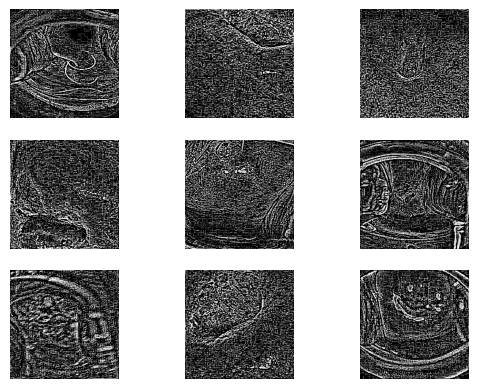

In [4]:
u1 = random.choice(x_data)
u2 = random.choice(x_data)
u3 = random.choice(x_data)
u4 = random.choice(x_data)
u5 = random.choice(x_data)
u6 = random.choice(x_data)
u7 = random.choice(x_data)
u8 = random.choice(x_data)
u9 = random.choice(x_data)

plt.subplot(331)
plt.imshow(u1, "gray"), plt.axis("off")
plt.subplot(332)
plt.imshow(u2, "gray"), plt.axis("off")
plt.subplot(333)
plt.imshow(u3, "gray"), plt.axis("off")
plt.subplot(334)
plt.imshow(u4, "gray"), plt.axis("off")
plt.subplot(335)
plt.imshow(u5, "gray"), plt.axis("off")
plt.subplot(336)
plt.imshow(u6, "gray"), plt.axis("off")
plt.subplot(337)
plt.imshow(u7, "gray"), plt.axis("off")
plt.subplot(338)
plt.imshow(u8, "gray"), plt.axis("off")
plt.subplot(339)
plt.imshow(u9, "gray"), plt.axis("off")

### **Ajuste y Equilibrado de los Datos**

In [5]:
x_numpy = np.array(x_data)
x_numpy = x_numpy.reshape(x_numpy.shape[0], (x_numpy.shape[1]*x_numpy.shape[2]))
df = pd.DataFrame(x_numpy)

series = pd.Series(y_data)
df["Tipo"] = series

Separo la variable objetivo de los datos.

In [6]:
Y_train = df.iloc[:, -1]
X_train = df.iloc[:,:-1]

Veo la cantidad de datos que tengo de cada tipo para poder equilibrarlos.

Tipo 1: 250
Tipo 2: 781
Tipo 3: 450
Proportion: 3:2 1.74 : 1
Proportion: 2:1 3.12 : 1
Proportion: 3:1 1.8 : 1


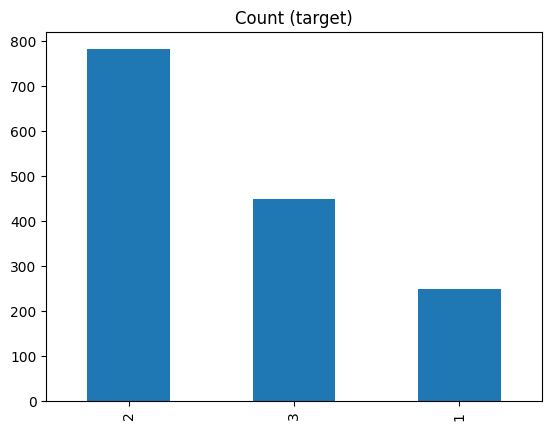

In [7]:
target_count = Y_train.value_counts()
print('Tipo 1:', target_count[1])
print('Tipo 2:', target_count[2])
print('Tipo 3:', target_count[3])
print('Proportion: 3:2', round(target_count[2] / target_count[3], 2), ': 1')
print('Proportion: 2:1', round(target_count[2] / target_count[1], 2), ': 1')
print('Proportion: 3:1', round(target_count[3] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

SMOTE-Tomek es un método de remuestreo que combina el método SMOTE (Synthetic Minority Over-sampling Technique) y Tomek Links para tratar el desbalance de clases en un conjunto de datos. SMOTE genera nuevas muestras sintéticas en el espacio de características para la clase minoritaria, mientras que Tomek Links elimina aquellas muestras de la clase mayoritaria que están más cerca de las muestras de la clase minoritaria.

Al hacer pruebas con el desbalanceamiento de los datos, pude observar que, el modelo tiene un mejor desempeño si dejo las clases con su desbalanceamiento original pero de una manera más leve. Aun que sobre el papel, el modelo debería aprender mejor si todas las clases estan balanceadas (ya que no debería clasificar las clases por su probabilidad a pertenecer a una u otra), desde mi punto de vista, dejar las clases algo desbalanceadas respetando las posiciones originales, puede ayudar al modelo, siendo esto un atributo más para realizar la clasificación.

Tipo 1: 650
Tipo 2: 799
Tipo 3: 699
Proportion: 2:3 1.14 : 1
Proportion: 2:1 1.23 : 1
Proportion: 1:3 0.93 : 1


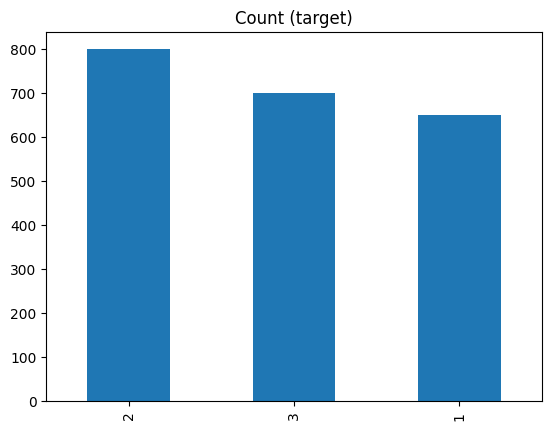

In [8]:
warnings.filterwarnings('ignore')

ratio={1:650, 2:800, 3:700}

smote_tomek = SMOTETomek(sampling_strategy=ratio, random_state=42)

X_st, y_st = smote_tomek.fit_resample(X_train, Y_train)

target_count = pd.Series(y_st).value_counts()
print('Tipo 1:', target_count[1])
print('Tipo 2:', target_count[2])
print('Tipo 3:', target_count[3])
print('Proportion: 2:3', round(target_count[2] / target_count[3], 2), ': 1')
print('Proportion: 2:1', round(target_count[2] / target_count[1], 2), ': 1')
print('Proportion: 1:3', round(target_count[1] / target_count[3], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

### **Primer Ajuste de HiperParámetros**

Hago un primer ajuste de HiperParámetros para tener una aproximación más o menos buena en el momento del primer entrenamiento, para poder sacar unas conclusiones más parecidas al modelo final. <br>
Optimizo los claficadores KNN y RandomForest ya que son los que van a estar más presentes en el entrenamiento.

In [11]:
param_grid_rForest = {
    'bootstrap': [True, False],
    'max_depth': [None, 10, 20, 30, 40, 50, 100, 200, 500],
    'max_features': ["sqrt", "log2", None],
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ["gini", "entropy", "log_loss"],
    'n_estimators': [int(x) for x in np.linspace(10, 1000, num=100)]
}

rForest_grid = RandomizedSearchCV(
    estimator=RandomForestClassifier(), param_distributions = param_grid_rForest, n_iter=20, cv=5, n_jobs=-1, verbose=2)

rForest_grid.fit(X_st, y_st)
rForest_grid.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'n_estimators': 180,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'gini',
 'bootstrap': False}

Fitting 5 folds for each of 20 candidates, totalling 100 fits <br><br>
{'n_estimators': 180,<br>
 'min_samples_split': 2,<br>
 'min_samples_leaf': 2,<br>
 'max_features': 'sqrt',<br>
 'max_depth': 30,<br>
 'criterion': 'gini',<br>
 'bootstrap': False}<br>

In [17]:
param_grid_KNN = {
    'n_neighbors': [int(x) for x in np.linspace(1, 100, num=50)],
    'leaf_size': [int(x) for x in np.linspace(1, 100, num=50)],
    'p': [1,2],
}

KNN_grid = GridSearchCV(
    estimator=KNeighborsClassifier(), param_grid = param_grid_KNN, cv=5, n_jobs=-1, verbose=2)

KNN_grid.fit(X_st, y_st)
KNN_grid.best_params_

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


{'leaf_size': 1, 'n_neighbors': 1, 'p': 1}

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits <br><br>
{'leaf_size': 1, 'n_neighbors': 1, 'p': 1}

### **Primer Entrenamiento**

Realizo un primer entrenamiento para ver cuáles son los clasificadores que mejor funcionan con estos datos. Para poder optimizar exhaustivamente sus parámetros y usarlos en el apartado del entrenamiento.

In [87]:
warnings.filterwarnings('ignore')

rf = RandomForestClassifier(n_estimators = 180,
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 'sqrt',
                            max_depth = 30,
                            criterion = 'gini',
                            bootstrap = False,
                            random_state=42,
                            n_jobs=-1)

knn = KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)
svc = SVC(kernel='rbf', probability=True, random_state=42)
sclf_pass_false = StackingClassifier(estimators=[('rf', rf), ('knn', knn)], passthrough=False, n_jobs = -1)
sclf_pass_true = StackingClassifier(estimators=[('rf', rf), ('knn', knn)], passthrough=True, n_jobs = -1)
vc = VotingClassifier(estimators=[('rf', rf), ('knn', knn), ('st', sclf_pass_false)], n_jobs = -1)
bag = BaggingClassifier(rf, n_estimators=10, max_samples=0.05, random_state=42, n_jobs = -1)
adaboost = AdaBoostClassifier(n_estimators=10, random_state=42)
gb = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, criterion='mse', max_depth=1, random_state=42)



regs = {
    "RandomForest": rf,
    "KNN": knn,
    "VotingClassifier": vc,
    "BaggingClassifier": bag,
    "AdaBoostClassifier": adaboost,
    "GradientBoosting": gb,
    "Stacking_con_passthrough": sclf_pass_true,
    "Stacking_sin_passthrough": sclf_pass_false    
}

scores1 = {
    "F1": []
}

for reg in regs.values():
    reg.fit(X_st, y_st)
    score1 = np.mean(cross_val_score(reg, X_st, y_st, cv=5, scoring='f1_macro', n_jobs=-1))
    scores1["F1"].append(score1)

scores1 = pd.DataFrame(scores1, index=regs.keys()).sort_values(by=['F1'], ascending=False)


scores1

c:\Python310\lib\site-packages\sklearn\ensemble\_gb.py:542: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\tree\_classes.py:397: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\tree\_classes.py:397: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\tree\_classes.py:397: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\tree\_classes.py:397: FutureWarning: Criterion 'mse' was deprecated in v1.0 an

,F1
Stacking_con_passthrough,0.796667
Stacking_sin_passthrough,0.763230
VotingClassifier,0.757420
RandomForest,0.621472
GradientBoosting,0.517254
KNN,0.489022
AdaBoostClassifier,0.488083
BaggingClassifier,0.459752


### **Ajuste Parámetros para el mejor modelo**

Optimizo los parámetros para el mejor modelo no perteneciente a ensembles ya que luego estos ensembles se compondrán de los modelos optimizados. <br>
Los mejores modelos que no pertenecen a ensembles son RandomForest, GradientBoosting y KNN por lo que optimizo los parametros para RandomForest y GradientBoosting ya que para KNN al no necesitar tanta capacidad de cómputo los optimicé con GridSearch.

**GridSearchCV** se utiliza para hacer búsqueda exhaustiva de parámetros, es decir, se evalúa el modelo con todas las posibles combinaciones de parámetros y selecciona la combinación que proporciona el mejor rendimiento. <br>
**RandomSearchCV** es como GridSearchCV pero en vez de evaluar todos los parámetros, elige combinaciones aleatorias para reducir el coste computacional. <br>
**Nevergrad** utiliza un enfoque de optimización basado en gradientes para encontrar los parámetros óptimos de un modelo. Primero, se especifica un objetivo a optimizar (como minimizar el error de un modelo) y luego se proporcionan los parámetros a optimizar. Nevergrad utiliza un algoritmo de optimización para ajustar iterativamente los parámetros de modo que se maximice o se minimice el objetivo especificado. Adicionalmente se puede modificar la variable de budget, para especificar el coste que se requiere para la optimización.<br><br>Por lo que a la hora de obtener el mejor resultado para la optimización de muchos parámetros nuestra mejor opción es Nevergrad. 


In [8]:
test_scores = []

def opt_rfc(n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, class_weight, X=X_st, y=y_st):

  cv = KFold(n_splits=5, shuffle=True, random_state=42)

  model = RandomForestClassifier(
    n_estimators=n_estimators, 
    criterion=criterion, 
    max_depth=max_depth,
    min_samples_split=min_samples_split, 
    min_samples_leaf=min_samples_leaf, 
    class_weight=class_weight, 
    random_state=22,
    n_jobs=-1
  )

  scores = cross_validate(model, X, y, cv=cv, scoring=('f1_macro'))
  f1 = np.mean(scores["test_score"])
  print(
    f"n_estimators: {n_estimators}, criterion: {criterion}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, class_weight: {class_weight}, f1: {f1}"
  )
  test_scores.append(f1)

  return -f1

n_estimators = ng.p.TransitionChoice(range(10, 1000, 100))
criterion = ng.p.Choice(["gini", "entropy"])
max_depth = ng.p.Choice(range(1, 500, 50))
min_samples_split = ng.p.TransitionChoice(range(2, 10, 1))
min_samples_leaf = ng.p.TransitionChoice(range(1, 10, 1))
class_weight = ng.p.Choice(["balanced", "balanced_subsample"])

params = ng.p.Instrumentation(n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, class_weight)
optimizer = ng.optimizers.TwoPointsDE(parametrization=params, budget=500)
with futures.ThreadPoolExecutor(max_workers=optimizer.num_workers) as executor:
  best = optimizer.minimize(opt_rfc, batch_mode=False, executor=executor)  

best.value

n_estimators: 810, criterion: gini, max_depth: 351, min_samples_split: 4, min_samples_leaf: 5, class_weight: balanced, f1: 0.6787056292244444
n_estimators: 710, criterion: entropy, max_depth: 201, min_samples_split: 2, min_samples_leaf: 5, class_weight: balanced_subsample, f1: 0.6780419895503182
n_estimators: 110, criterion: gini, max_depth: 351, min_samples_split: 7, min_samples_leaf: 4, class_weight: balanced, f1: 0.6805066915184488
n_estimators: 310, criterion: entropy, max_depth: 201, min_samples_split: 5, min_samples_leaf: 2, class_weight: balanced_subsample, f1: 0.6785730799196521
n_estimators: 610, criterion: entropy, max_depth: 1, min_samples_split: 7, min_samples_leaf: 9, class_weight: balanced_subsample, f1: 0.4392976062423172
n_estimators: 410, criterion: gini, max_depth: 351, min_samples_split: 7, min_samples_leaf: 4, class_weight: balanced, f1: 0.679361658682146
n_estimators: 610, criterion: entropy, max_depth: 201, min_samples_split: 9, min_samples_leaf: 4, class_weight: 

c:\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


n_estimators: 910, criterion: entropy, max_depth: 101, min_samples_split: 2, min_samples_leaf: 1, class_weight: balanced, f1: 0.6856753771939792
n_estimators: 810, criterion: gini, max_depth: 51, min_samples_split: 5, min_samples_leaf: 2, class_weight: balanced, f1: 0.6825095278082799
n_estimators: 910, criterion: gini, max_depth: 401, min_samples_split: 2, min_samples_leaf: 1, class_weight: balanced_subsample, f1: 0.6809992025859857
n_estimators: 810, criterion: entropy, max_depth: 251, min_samples_split: 5, min_samples_leaf: 1, class_weight: balanced, f1: 0.6849439579340417
n_estimators: 810, criterion: entropy, max_depth: 401, min_samples_split: 2, min_samples_leaf: 1, class_weight: balanced_subsample, f1: 0.683184776689902
n_estimators: 110, criterion: gini, max_depth: 101, min_samples_split: 2, min_samples_leaf: 2, class_weight: balanced, f1: 0.6781033611137083
n_estimators: 610, criterion: entropy, max_depth: 301, min_samples_split: 2, min_samples_leaf: 1, class_weight: balanced_

((710, 'gini', 51, 2, 1, 'balanced'), {})

In [38]:
warnings.filterwarnings('ignore')

test_scores1 = []

def opt_rfc1(learning_rate, n_estimators, subsample, criterion, min_samples_split, min_samples_leaf, max_depth, max_features, X=X_st, y=y_st):

  cv = KFold(n_splits=5, shuffle=True, random_state=42)

  model1 = GradientBoostingClassifier(
    learning_rate = learning_rate,
    n_estimators = n_estimators,
    subsample = subsample,
    criterion = criterion,
    min_samples_split = min_samples_split,
    min_samples_leaf = min_samples_leaf,
    max_depth = max_depth,
    max_features = max_features,
    random_state=22
  )

  scores1 = cross_validate(model1, X, y, cv=cv, scoring=('f1_macro'))
  f1 = np.mean(scores1["test_score"])
  print(
    f"learning_rate: {learning_rate}, n_estimators: {n_estimators}, subsample: {subsample}, criterion: {criterion}, min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}, max_depth: {max_depth}, max_features: {max_features}, f1: {f1}"
  )
  test_scores1.append(f1)

  return -f1


learning_rate = ng.p.Choice([0.0001,0.001, 0.01, 0.1])
n_estimators = ng.p.TransitionChoice(range(50,551,50))
subsample = ng.p.TransitionChoice([i/10.0 for i in range(1,11)])
criterion = ng.p.Choice(["friedman_mse", "squared_error"])
min_samples_split = ng.p.TransitionChoice([i/10.0 for i in range(1,11)])
min_samples_leaf = ng.p.TransitionChoice([i/10.0 for i in range(1,11)])
max_depth = ng.p.TransitionChoice(range(1,21,1))
max_features = ng.p.Choice(["auto", "sqrt", "log2"])


params1 = ng.p.Instrumentation(learning_rate, n_estimators, subsample, criterion, min_samples_split, min_samples_leaf, max_depth, max_features)
optimizer1 = ng.optimizers.TwoPointsDE(parametrization=params1, budget=500)
with futures.ThreadPoolExecutor(max_workers=optimizer.num_workers) as executor:
  best = optimizer1.minimize(opt_rfc1, batch_mode=False, executor=executor)  

best.value

learning_rate: 0.1, n_estimators: 450, subsample: 0.4, criterion: squared_error, min_samples_split: 0.5, min_samples_leaf: 0.2, max_depth: 2, max_features: sqrt, f1: 0.18068565500152922
learning_rate: 0.1, n_estimators: 200, subsample: 0.1, criterion: friedman_mse, min_samples_split: 0.6, min_samples_leaf: 0.2, max_depth: 13, max_features: log2, f1: 0.18068565500152922
learning_rate: 0.0001, n_estimators: 550, subsample: 0.9, criterion: squared_error, min_samples_split: 0.3, min_samples_leaf: 0.9, max_depth: 16, max_features: sqrt, f1: 0.18068565500152922
learning_rate: 0.1, n_estimators: 50, subsample: 0.6, criterion: squared_error, min_samples_split: 0.3, min_samples_leaf: 0.4, max_depth: 11, max_features: auto, f1: 0.18068565500152922
learning_rate: 0.001, n_estimators: 250, subsample: 1.0, criterion: friedman_mse, min_samples_split: 1.0, min_samples_leaf: 0.7, max_depth: 9, max_features: log2, f1: 0.18068565500152922
learning_rate: 0.001, n_estimators: 150, subsample: 0.8, criterio

### **Entrenamiento**

Una vez decididos cuales son los mejores parámetros para cada modelo y cuál es el modelo que mejor clasifica las imágenes, lo uso en el entrenamiento.

En cuanto a los dos StackingClassifier, con el argumento passthrough=False, combina los resultados de cada modelo utilizando un modelo adicional. El modelo con argumento passthrough=True simplemente pasa los resultados de cada modelo.

In [9]:
#warnings.filterwarnings('ignore')

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(n_estimators = 710,
                            criterion = 'gini',
                            max_depth = 51,
                            min_samples_split = 2,
                            min_samples_leaf = 1,
                            class_weight = 'balanced',
                            random_state=42,
                            n_jobs=-1)

knn = KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)

gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators = 400, subsample = 0.8, criterion= "squared_error", min_samples_split=0.3, min_samples_leaf=0.1, max_depth=4, max_features=1.0, random_state=42)


sclf_pass_false = StackingClassifier(estimators=[('rf', rf), ('knn', knn)], passthrough=False, n_jobs = -1)
sclf_pass_true = StackingClassifier(estimators=[('rf', rf), ('knn', knn)], passthrough=True, n_jobs = -1)


regs = {
    "Stacking_con_passthrough": sclf_pass_true
}

scores1 = {
    "F1": []
}

for reg in regs.values():
    reg.fit(X_st, y_st)
    score1 = np.mean(cross_val_score(reg, X_st, y_st, cv=cv, scoring='f1_macro', n_jobs=-1))
    scores1["F1"].append(score1)

scores1 = pd.DataFrame(scores1, index=regs.keys()).sort_values(by=['F1'], ascending=False)

scores1

,F1
Stacking_con_passthrough,0.781929


### **Predicción**

In [10]:
test_data = []

preprocess("E:/Clase/SI/Data/test/", test_data)

test_data = np.array(test_data)
test_data = test_data.reshape(test_data.shape[0], (test_data.shape[1]*test_data.shape[2]))

y_test_pred = sclf_pass_true.predict(test_data)

prediction = pd.DataFrame()
prediction["Tipo"] = y_test_pred

prediction

,Tipo
0,2
1,2
2,2
3,2
4,2
...,...
507,2
508,2
509,3
510,2


### **Demostración con algunos ejemplos**

Como las imágenes del test no estan etiquetadas, usaremos las imagenes adicionales aportadas por kaggle (que no han sido usadas en el train, ni en el test), para poder ver claramente el desempeño del modelo entrenado.

In [46]:
sel = []

#Aplico la funcion del preprocesamiento para las imagenes adicionales.

preprocess("E:/Clase/SI/Data/additional_Type1/", sel)
y_sel1 = np.ones((len(sel),), dtype=int)

preprocess("E:/Clase/SI/Data/additional_Type2/", sel)
y_sel2 = np.full(len(sel)-len(y_sel1), 2)

preprocess("E:/Clase/SI/Data/additional_Type3/", sel)
y_sel3 = np.full(len(sel)-len(y_sel1)-len(y_sel2), 3)

y_sel = np.concatenate((y_sel1, y_sel2, y_sel3), axis = 0)

#Organizo los datos en un dataframe

x_numpy_sel = np.array(sel)
x_numpy_sel = x_numpy_sel.reshape(x_numpy_sel.shape[0], (x_numpy_sel.shape[1]*x_numpy_sel.shape[2]))
df = pd.DataFrame(x_numpy_sel)

series = pd.Series(y_sel)
df["Tipo"] = series

Y_sel = df.iloc[:, -1]
X_sel = df.iloc[:,:-1]

#Selecciono 3 imágenes al azar

sample = X_sel.sample(n=3)

#Realizo la predicción

sample_predict = sclf_pass_true.predict(sample)

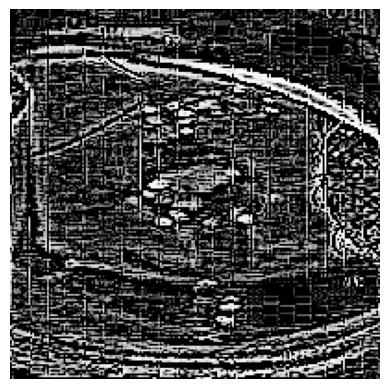

Para el índice 9: 
 El Tipo predicho es: 1 
 El Tipo real es: 1


In [47]:
plt.imshow(x_data[sample.index[0]], "gray"), plt.axis("off")
plt.show()

print("Para el índice {}: \n El Tipo predicho es: {} \n El Tipo real es: {}".format(sample.index[0], sample_predict[0], Y_sel[sample.index[0]]))

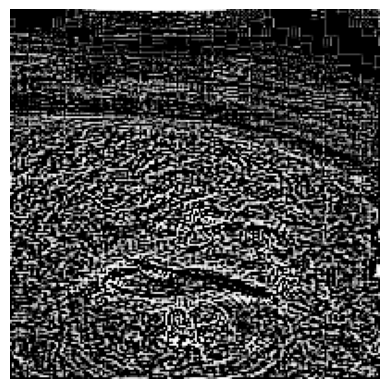

Para el índice 1: 
 El Tipo predicho es: 2 
 El Tipo real es: 1


In [48]:
plt.imshow(x_data[sample.index[1]], "gray"), plt.axis("off")
plt.show()

print("Para el índice {}: \n El Tipo predicho es: {} \n El Tipo real es: {}".format(sample.index[1], sample_predict[1], y_st[sample.index[1]]))

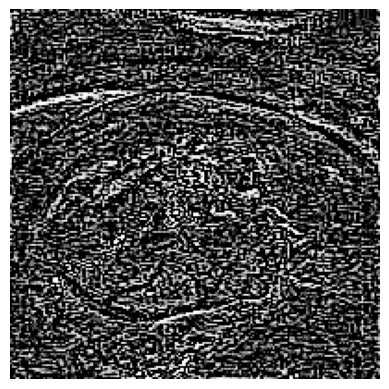

Para el índice 4: 
 El Tipo predicho es: 1 
 El Tipo real es: 1


In [49]:
plt.imshow(x_data[sample.index[2]], "gray"), plt.axis("off")
plt.show()

print("Para el índice {}: \n El Tipo predicho es: {} \n El Tipo real es: {}".format(sample.index[2], sample_predict[2], y_st[sample.index[2]]))

### 
<hr>

Creado por **Javier Gil** (javier.gil.rodriguez@alumnos.upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">